In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
from jax import jit
from jax import random
from jax import numpy as jnp
from jax.example_libraries import optimizers

import numpy as np

from matplotlib import pyplot as plt

from vae import HyperParams, build_vae
from datasets import get_mnist

TypeError: 'type' object is not subscriptable

In [ ]:
mnist = get_mnist()

In [ ]:
hps = HyperParams(encoder_width = 100, decoder_width = 100, latent_size = 10)
init_vae, run_vae = build_vae(hps)

In [ ]:
def evaluate_idxs(params, idxs, rng):
  plt.figure(figsize=(10,30))
  for idx in idxs:
    img = mnist["train_x"][idx]
    elbo, logits, logpx, logpz, logqz = run_vae(params, img, rng=rng)
    recon = 1 / (1 + jnp.exp(-logits))

    print(idx, elbo, logpx, logpz, logqz)

    plt.subplot(len(idxs)*2, 2, idx*2+1)
    plt.imshow(np.array(img).reshape((28, 28)), cmap="gray")

    plt.subplot(len(idxs)*2, 2, idx*2+2)
    plt.imshow(np.array(recon).reshape((28, 28)), cmap="gray")

In [ ]:
init_rng = random.PRNGKey(1)
_, init_params = init_vae(rng=init_rng, input_shape=(28 * 28,))

0 -547.3189 -546.31854 -14.322887 -13.322481
1 -548.3541 -546.258 -15.418643 -13.322481
2 -545.5951 -544.9249 -13.992683 -13.322481
3 -551.68976 -549.0449 -15.967321 -13.322481
4 -553.6472 -550.37933 -16.590416 -13.322481


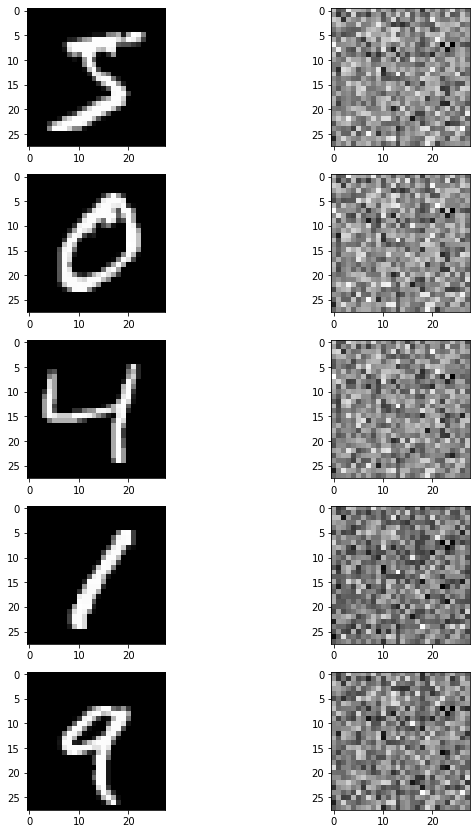

In [ ]:
evaluate_idxs(init_params, range(5), rng=random.PRNGKey(2))

In [ ]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4, eps=1e-4)

def loss_fn(rng, params, image):
  elbo, _, _, _, _ = run_vae(params, image, rng=rng)
  return -elbo

@jit
def run_epoch(rng, opt_state):
  images = mnist["train_x"][:10]
  num_images = images.shape[0]
  rngs = random.split(rng, num_images)

  def body_fn(opt_state, args):
    i, rng, image = args
    loss, g = jax.value_and_grad(loss_fn, argnums=1)(rng, get_params(opt_state), image)
    return opt_update(i, g, opt_state), loss

  res, losses = jax.lax.scan(body_fn, opt_state, (jnp.arange(num_images), rngs, images))
  return res, jnp.mean(losses)

In [ ]:
num_epochs = 6000
opt_state = opt_init(init_params)
rng = random.PRNGKey(0)
for epoch in range(1, num_epochs+1):
  rng, epoch_rng = random.split(rng)
  opt_state, loss = run_epoch(rng, opt_state)
  if epoch % 500 == 0:
    print(epoch, loss)

500 144.89903
1000 99.99172
1500 57.690845
2000 32.52657
2500 16.071714
3000 9.290973
3500 2.884135
4000 1.2205164
4500 -0.9323419
5000 -2.1564567
5500 -1.9814934
6000 -2.8745115


0 1.0576448 -1.2673304 -10.00376 -12.328735
1 0.630805 -1.9036647 -9.794266 -12.328735
2 1.9100494 -0.5911888 -9.8274975 -12.328735
3 1.2499914 -1.3441108 -9.734633 -12.328735
4 1.1412497 -1.3270597 -9.860426 -12.328735


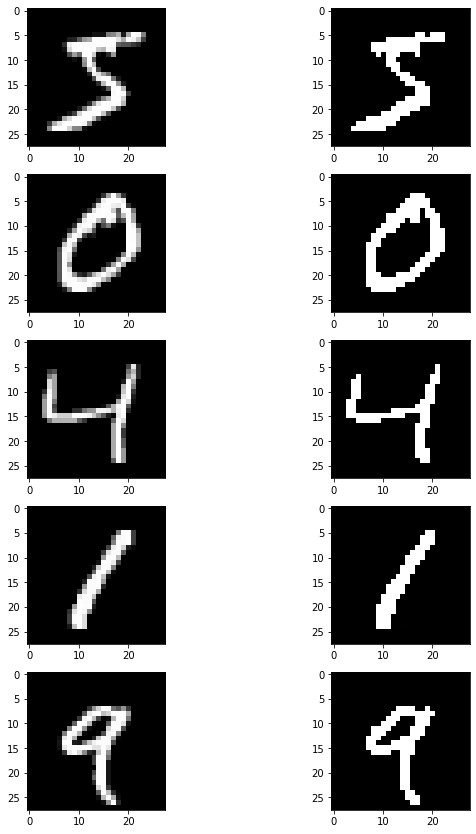

In [ ]:
evaluate_idxs(get_params(opt_state), range(5), rng=random.PRNGKey(1))